### Training 

The srbm is trained with data similar to the one used by Finnegan et al. (2015)

Data loaded from data/data_data_uniform_variations_100.pkl

Variations per prototype in train set after train-test-split: 9
Variations per prototype in test set after train-test-split:  1

Each group consists of 45 randomized patterns. 
The patterns for the first group consist of the 9 variations of the first of the 10 prototypes 
that were generated for each of the 5 seed patterns. 
Practically, that means that the first group consists of the 9 variations of the first prototype 
generated of the first seed pattern + the 9 variations of the first prototype generated of the second 
seed pattern, etc., making 45 patterns in total. 
The second group consists of the 9 variations of the second prototype generated of the first seed 
pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.


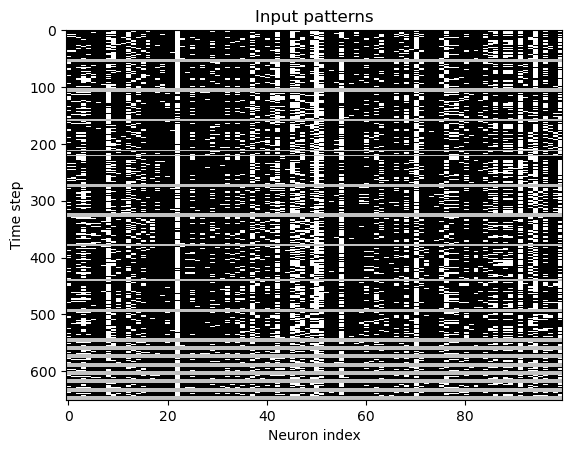

The input patterns are shown above. 
After each group of 45 patterns, test patterns for each prototype are shown. 
In the end all test patterns are shown. 



In [17]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *
from tools.parameters import *
from generate_data import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

# Some parameters for training the SRBM - the others are in paramters_main.py

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_data_uniform_variations_100")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)

print("\nVariations per prototype in train set after train-test-split: " + str(len(train_test_data[0][0])))
print("Variations per prototype in test set after train-test-split:  " + str(len(train_test_data[1][0])))

off_time = 1 # How many frames should be after a test pattern before the next test pattern is presented?

# Create the Ids. Test patterns are not randomized!
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

print("\nEach group consists of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " randomized patterns. \n" +
      "The patterns for the first group consist of the " + str(len(train_test_data[0][0])) + " variations of " + 
      "the first of the " + str(n_prototype_per_seed) +  " prototypes \nthat were generated for each of the " + str(n_seed_patterns) + " seed patterns. \n" + 
      "Practically, that means that the first group consists of the 9 variations of the first prototype \n" + 
      "generated of the first seed pattern + the 9 variations of the first prototype generated of the second \n" + 
      "seed pattern, etc., making " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns in total. \n" + 
      "The second group consists of the 9 variations of the second prototype generated of the first seed \n" + 
      "pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.")

fig, ax = plt.subplots()
plt.imshow(Ids, cmap='gray', aspect='auto', interpolation= "None")
plt.xlabel("Neuron index")
plt.ylabel("Time step")
plt.title("Input patterns")
plt.show()
print("The input patterns are shown above. \n" +
      "After each group of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns, test patterns for each prototype are shown. \n" + 
      "In the end all test patterns are shown. \n")



In [18]:
## shorten ids for trials!
Ids = Ids[0:60] 
#Ids = np.repeat(Ids[1], 30).reshape(200, 30).T

In [19]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

# Calculate simulation time for accurate neural growth
sim_time = (t_sim / (dcmt*t_ref))

In [30]:
6.5*0.6+8*0.4

7.1

In [20]:
# SRBM main function
# leak helper is sensistivity ov average
print("Starting the SRBM simulation...")
out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, p_target = 1e-10, 
           sparsity_cost = 1e-4 * 0 , leak_helper = 10, dorun = True, n_classes = 5, 
            monitors = True, display=False, age_neurons = False, generations = 3, 
            connectivity_born=0.2, connectivity_mature=0.2, lock_connectivity = False) # set display to false if no lables are used 
locals().update(out)

Starting the SRBM simulation...
ageing factor:  0.8333333333333327


INFO:root:building '_cython_magic_da57e4ac3d33dcb8309ce7fd2c51f579' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -D_FORTIFY_SOURCE=2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -I/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -I/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/numpy/core/include -I/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/brian2/synapses -I/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include/python3.9 -c /Users/daniel/Library/Caches/cython/brian_extensions/_cython_

Starting simulation at t=0. s for a duration of 14.4 s
8.9404 s (62%) simulated in 10s, estimated 6s remaining.
14.4 s (100%) simulated in 16s
20.545285940170288


In [21]:
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
sMhh_age = out["sMhh_age"]
sMhh_av_act = out["sMhh_av_act"]
sMh_age = out["sMh_age"]
sMh_v = out["sMh_v"]
sMhh_age = out["sMhh_age"]
sMh_q = out["sMh_q"]
weights = out["weights"]
connections = out["connections"]

In [22]:
""" import pandas as pd
df = pd.DataFrame(weights)
df.to_csv("weights.csv") """

' import pandas as pd\ndf = pd.DataFrame(weights)\ndf.to_csv("weights.csv") '

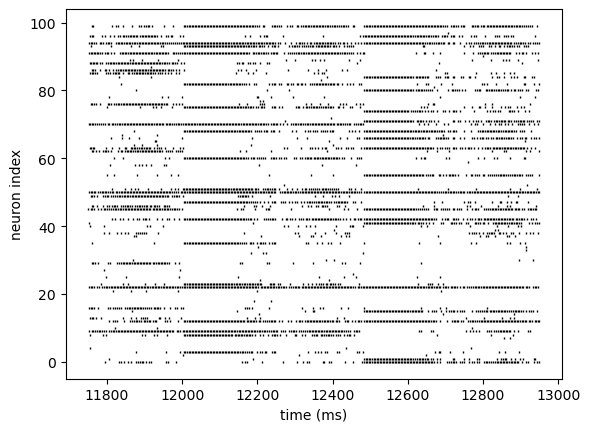

In [23]:
t_start = 49
t_stop = 53
precision = 1
idx_start = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mv.i[idx_start:idx_stop], Mv.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()

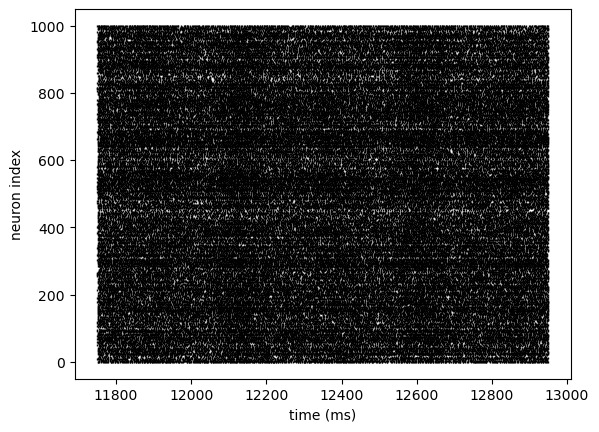

' # Some plots - use only with small trial sets!\nn_neurons = 1\nfor i in np.arange(n_neurons):\n    plt.plot(sMh_age.t/ms, gomperz_function(sMh_age.age[i]+0.8, 10), linewidth=1) ## gompertz is now set to +0.8, 10!!!\nplt.ylim(-0.2, 1.2)\n\nplt.show() '

In [8]:
t_start = 49
t_stop = 53
precision = 1
idx_start = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mh.i[idx_start:idx_stop], Mh.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()


""" # Some plots - use only with small trial sets!
n_neurons = 1
for i in np.arange(n_neurons):
    plt.plot(sMh_age.t/ms, gomperz_function(sMh_age.age[i]+0.8, 10), linewidth=1) ## gompertz is now set to +0.8, 10!!!
plt.ylim(-0.2, 1.2)

plt.show() """


In [9]:
""" n_neurons = 4
for i in np.arange(n_neurons):
    plt.plot(sMhh_av_act.t/ms, sMh_v.v[i], label='Neuron ' + str(i), linewidth=0.5)
plt.legend(loc=2, prop={'size': 8})

plt.show() """


" n_neurons = 4\nfor i in np.arange(n_neurons):\n    plt.plot(sMhh_av_act.t/ms, sMh_v.v[i], label='Neuron ' + str(i), linewidth=0.5)\nplt.legend(loc=2, prop={'size': 8})\n\nplt.show() "

In [10]:

""" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)
#plt.ylim(0, 0.01)
#plt.legend(loc=2, prop={'size': 8})

plt.show() """



#plot_raster(Mh.i, Mh.t, markersize=2,marker='|', color='k', mew=1)
#plt.show()

" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)\n#plt.ylim(0, 0.01)\n#plt.legend(loc=2, prop={'size': 8})\n\nplt.show() "

In [11]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

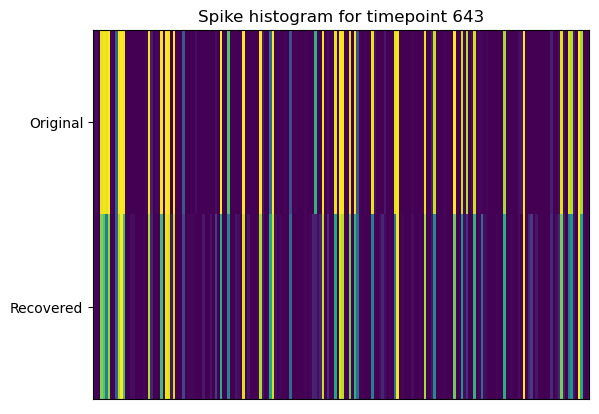

In [12]:
timepoint = 643 # for which timepoint should the spike histogram be plotted?

t_start_stimulus = time_points_dict["T"+ str(timepoint)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(timepoint)+"_e"]
t_start_recover = time_points_dict["T"+ str(timepoint+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(timepoint+off_time)+"_e"]
orig = spike_histogram(Mv, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(Mv, t_start=t_start_recover+0.01*second, t_stop=t_stop_recover).T[1]

fig, ax = plt.subplots()
plt.imshow(np.row_stack((normalizer(orig), normalizer(recover))), aspect='auto', interpolation= "None")
plt.yticks(np.linspace(0, 1, 2),["Original", "Recovered"])
plt.title("Spike histogram for timepoint " + str(timepoint))
ax.set_xticks([])
plt.show()

In [13]:
# Function to save the output of the SRBM simulation
def save_output(unique = "", date = ""):
    '''Saves the output of the SRBM simulation in a pickle file.'''
    import pickle
    k_v, v_v = zip(*Mv.spike_trains().items())
    k_h, v_h = zip(*Mh.spike_trains().items())
    output = {"Mv": {"i":np.array(Mv.i), "t":np.array(Mv.t), 
                     "k": k_v, "v": v_v}, 
              "Mh": {"i":np.array(Mh.i), "t":np.array(Mh.t), 
                     "k": k_h, "v": v_h},
              "time_test_on":time_test_on,
              "time_test_off":time_test_off,
              "Ids":Ids,
              "timepoints":timepoints,
              "t_sim":t_sim,
              "time_points_dict":time_points_dict,
              "W":W,
              "b_v":b_v,
              "b_c":b_c,
              "b_h":b_h,
              "mB":mB,
              "Wvh":Wvh,
              "Wch":Wch,
              "mBv":mBv,
              "mBh":mBh,
              "sim_time":sim_time,
              "N_v":N_v,
              "N_c":N_c,
              "N_h":N_h,
              "beta_parameter":beta_parameter,
              "tau_rec":tau_rec,
              "dcmt":dcmt,
              "off_time":off_time,
              "n_seed_patterns": n_seed_patterns,
              "n_prototype_per_seed": n_prototype_per_seed,
              "n_variations_per_prototype": n_variations_per_prototype, 
              "after_split_n_per_prototype_train": len(train_test_data[0][0]), 
              "after_split_n_per_prototype_test": len(train_test_data[1][0])}                                 
    with open('output/'+unique+date+'.pkl', 'wb') as handle: # Python 3:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Output saved as output/"+unique+date+".pkl")

In [14]:
# Save the output to open in the evaluation notebook
save_output(unique = "output_200_ageing_c02_locked", date = "")

Output saved as output/output_200_ageing_c02_locked.pkl
